## Resnet from scratch

Just trying to build resnet from scratch on my own without peeking as much as possible.

## Import libraries

This is an exception :)

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.xtras import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
dls = get_dls(num_workers=2)
xb, yb = next(iter(dls.train))
xb.shape, yb

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4,  ..., 8, 0, 3]))

## Convolutional net

Let's start with a conv net and go from there. In [Schedular blog](https://galopyz.github.io/delicious-nbdev/blog/posts/2023-11-17-Scheduler/), we had four convolutional layers. To improve the score, we can add one more layer. Let's see how that makes a difference.

In [58]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

nfs = [1,8,16,32,64,128]
def get_model():
    layers = [conv(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [59]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  100026


|Module|Input|Output|Num params|
|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 8, 14, 14)|96|
|Sequential|(1024, 8, 14, 14)|(1024, 16, 7, 7)|1200|
|Sequential|(1024, 16, 7, 7)|(1024, 32, 4, 4)|4704|
|Sequential|(1024, 32, 4, 4)|(1024, 64, 2, 2)|18624|
|Sequential|(1024, 64, 2, 2)|(1024, 128, 1, 1)|74112|
|AdaptiveAvgPool2d|(1024, 128, 1, 1)|(1024, 128, 1, 1)|0|
|Flatten|(1024, 128, 1, 1)|(1024, 128)|0|
|Linear|(1024, 128)|(1024, 10)|1290|


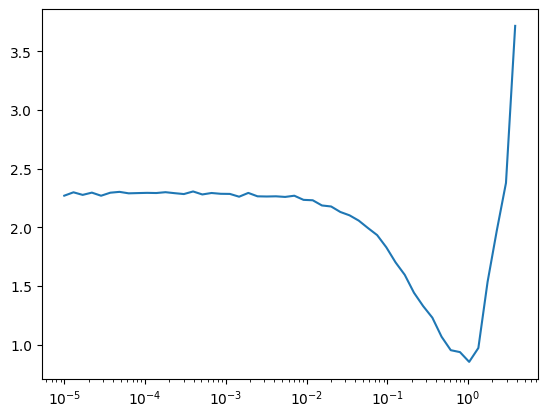

In [60]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.775,0.658,0,True,00:03
0.838,0.522,0,False,00:00
0.865,0.362,1,True,00:02
0.858,0.398,1,False,00:00
0.891,0.290,2,True,00:03
0.884,0.320,2,False,00:00
0.909,0.242,3,True,00:03
0.900,0.277,3,False,00:00
0.926,0.199,4,True,00:02
0.906,0.256,4,False,00:00


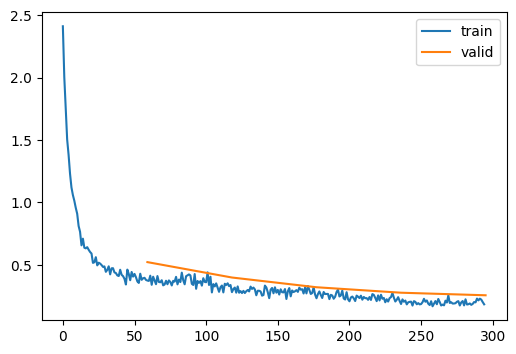

In [63]:
lr, epochs = 6e-2, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtras = [BatchSchedCB(sched)]
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

That's an improvement. However, we want to do better. Let's use Resnet we learned in [Resnet blog](https://galopyz.github.io/delicious-nbdev/blog/posts/2023-12-04-Resnet/).

## Resnet

In [68]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, ni, ks=ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(ni, nf, ks=ks, stride=2, act=act, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [69]:
def get_model(act=act_gr, norm=nn.BatchNorm2d):
    layers = [ConvBlock(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [70]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  149358


|Module|Input|Output|Num params|
|--|--|--|--|
|ConvBlock|(1024, 1, 28, 28)|(1024, 8, 14, 14)|108|
|ConvBlock|(1024, 8, 14, 14)|(1024, 16, 7, 7)|1800|
|ConvBlock|(1024, 16, 7, 7)|(1024, 32, 4, 4)|7056|
|ConvBlock|(1024, 32, 4, 4)|(1024, 64, 2, 2)|27936|
|ConvBlock|(1024, 64, 2, 2)|(1024, 128, 1, 1)|111168|
|AdaptiveAvgPool2d|(1024, 128, 1, 1)|(1024, 128, 1, 1)|0|
|Flatten|(1024, 128, 1, 1)|(1024, 128)|0|
|Linear|(1024, 128)|(1024, 10)|1290|


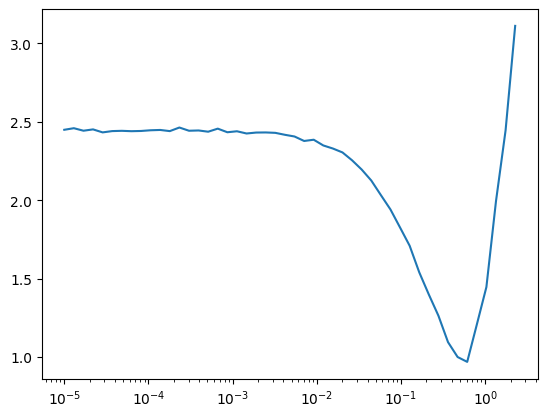

In [71]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.760,0.689,0,True,00:02
0.721,0.982,0,False,00:00
0.859,0.381,1,True,00:02
0.636,1.218,1,False,00:00
0.883,0.311,2,True,00:02
0.881,0.314,2,False,00:00
0.905,0.253,3,True,00:02
0.902,0.262,3,False,00:00
0.923,0.208,4,True,00:03
0.907,0.248,4,False,00:00


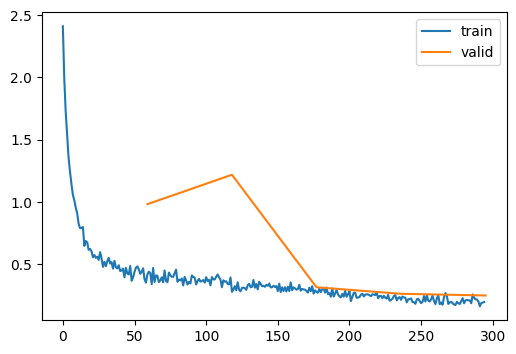

In [73]:
lr, epochs = 8e-2, 5
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

### Modifying `ConvBlock`

Instead of changing number of features and stride at the same, it might be useful to separate them out. First, we increase the features with stride one. It's like paying closely attention to details and saving them into bigger number of features.

In [90]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, nf, ks=ks, stride=1, act=act, norm=norm)
        self.conv2 = conv(nf, nf, ks=ks, stride=stride, act=act, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [91]:
def get_model(act=act_gr, norm=nn.BatchNorm2d):
    layers = [ConvBlock(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [92]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  297186


|Module|Input|Output|Num params|
|--|--|--|--|
|ConvBlock|(1024, 1, 28, 28)|(1024, 8, 14, 14)|696|
|ConvBlock|(1024, 8, 14, 14)|(1024, 16, 7, 7)|3552|
|ConvBlock|(1024, 16, 7, 7)|(1024, 32, 4, 4)|14016|
|ConvBlock|(1024, 32, 4, 4)|(1024, 64, 2, 2)|55680|
|ConvBlock|(1024, 64, 2, 2)|(1024, 128, 1, 1)|221952|
|AdaptiveAvgPool2d|(1024, 128, 1, 1)|(1024, 128, 1, 1)|0|
|Flatten|(1024, 128, 1, 1)|(1024, 128)|0|
|Linear|(1024, 128)|(1024, 10)|1290|


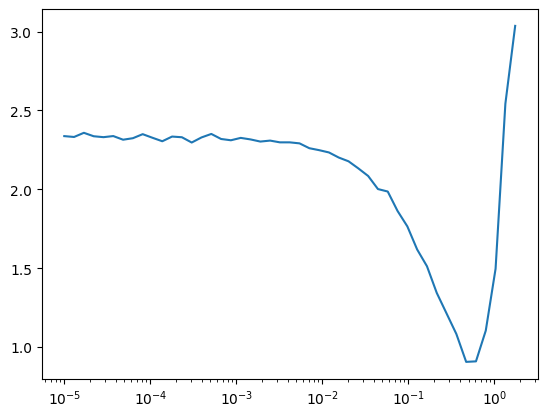

In [77]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.800,0.581,0,True,00:03
0.812,0.889,0,False,00:00
0.867,0.364,1,True,00:03
0.849,0.452,1,False,00:01
0.892,0.287,2,True,00:03
0.860,0.390,2,False,00:00
0.917,0.226,3,True,00:03
0.905,0.259,3,False,00:01
0.931,0.185,4,True,00:03
0.917,0.232,4,False,00:01


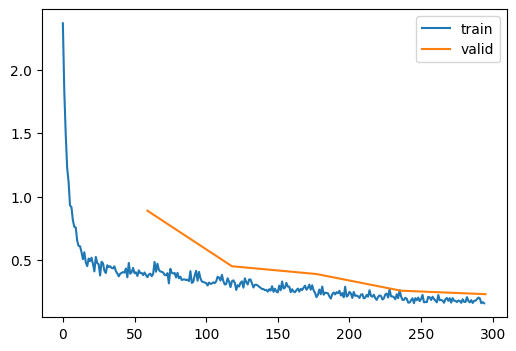

In [94]:
lr, epochs = 8e-2, 5
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

How about if we stride first? I don't think it would be better than the previous approach, but let's see how it performs.

In [83]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, act=act_gr, norm=nn.BatchNorm2d):
        super().__init__()
        self.conv1 = conv(ni, ni, ks=ks, stride=stride, act=act, norm=norm)
        self.conv2 = conv(ni, nf, ks=ks, stride=1, act=act, norm=norm)
    
    def forward(self, x):
        return self.conv2(self.conv1(x))

In [84]:
def get_model(act=act_gr, norm=nn.BatchNorm2d):
    layers = [ConvBlock(nfs[i], nfs[i+1], act=act_gr, norm=nn.BatchNorm2d) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(nfs[-1], 10)]
    return nn.Sequential(*layers).apply(iw)

In [85]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  149358


|Module|Input|Output|Num params|
|--|--|--|--|
|ConvBlock|(1024, 1, 28, 28)|(1024, 8, 14, 14)|108|
|ConvBlock|(1024, 8, 14, 14)|(1024, 16, 7, 7)|1800|
|ConvBlock|(1024, 16, 7, 7)|(1024, 32, 4, 4)|7056|
|ConvBlock|(1024, 32, 4, 4)|(1024, 64, 2, 2)|27936|
|ConvBlock|(1024, 64, 2, 2)|(1024, 128, 1, 1)|111168|
|AdaptiveAvgPool2d|(1024, 128, 1, 1)|(1024, 128, 1, 1)|0|
|Flatten|(1024, 128, 1, 1)|(1024, 128)|0|
|Linear|(1024, 128)|(1024, 10)|1290|


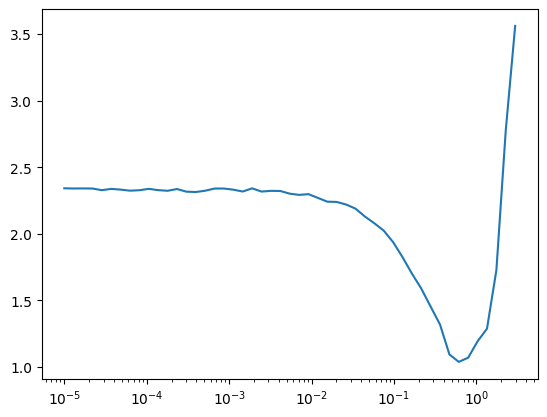

In [86]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

accuracy,loss,epoch,train,time
0.730,0.763,0,True,00:02
0.757,0.908,0,False,00:00
0.843,0.423,1,True,00:03
0.834,0.463,1,False,00:00
0.872,0.340,2,True,00:03
0.867,0.365,2,False,00:00
0.892,0.286,3,True,00:03
0.878,0.328,3,False,00:00
0.907,0.247,4,True,00:03
0.891,0.298,4,False,00:00


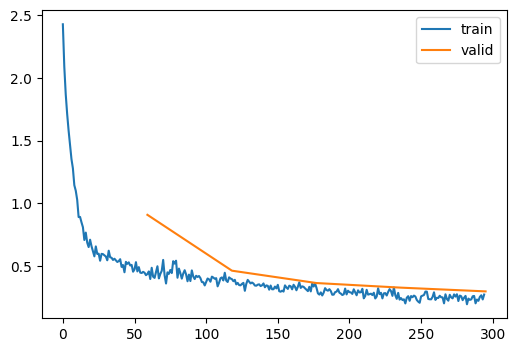

In [89]:
lr, epochs = 1e-1, 5
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=cbs+xtras, opt_func=optim.AdamW)
learn.fit(epochs)

As expected, first modification is the best. Let's see how `Resnet` performs now.